In [1]:
#!/usr/bin/env python
# encoding: utf-8
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate
from tensorflow.keras.layers import ActivityRegularization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers , initializers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator



gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
# from xgboost import XGBClassifier
import tensorflow.keras.backend as K
from sklearn import metrics
from joblib import dump, load

# !pip3 install keras-tuner --upgrade
# !pip3 install autokeras
import kerastuner as kt
import autokeras as ak

#Plot's Making  Packages
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib import font_manager


# Import local libraries
import numpy as np
import h5py
import time
import pandas as pd
import importlib
from scipy import interpolate
import os
from tqdm import tqdm 

import logging

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

os.environ['NUMEXPR_MAX_THREADS'] = '64'
os.environ['NUMEXPR_NUM_THREADS'] = '64'

print("Tensorflow Version is {}".format(tf.__version__))
print("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.device('/device:XLA_GPU:0')
!nvidia-smi

%config InlineBackend. figure_format = 'retina'

1 Physical GPUs, 1 Logical GPU
Tensorflow Version is 2.4.1
Keras Version is 2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2901682516232305404
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1048576000
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 17617081232922822530
physical_device_desc: "device: 0, name: A100-SXM-80GB, pci bus id: 0000:4c:00.0, compute capability: 8.0"
]
Wed Feb 23 01:39:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|=============================

In [2]:
%%time
HOMEPATH = "/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/"
datapath = HOMEPATH + "Data_ML/Data_High_Level_Features/"


data_train = {
        "herwig_ang_train" : 0,
        "pythia_def_train" : 0,
        "pythia_vin_train" : 0,
        "pythia_dip_train" : 0,
        }  

for j, traindata in enumerate(data_train):
    
    train_data_path = HOMEPATH + "Notebook/KFold/" + str(traindata) + ".csv"
    if os.path.exists(train_data_path):
        tmp = pd.read_csv(train_data_path)
            
    tmp = tmp[(tmp["PTJ_0"] >= 300)  & (tmp["PTJ_0"] < 500)]
    tmp = tmp[(tmp["MJ_0"] >= 110)  & (tmp["MJ_0"] < 160)]

    data_train[traindata] = tmp
    logging.info("START===========================================START")
    logging.info("\r") 
    logging.info("All Files are loaded!")
    logging.info("pt min: {} , pt max: {}".format(300, 500))
    logging.info("\r")
    logging.info("H jet : QCD jet = 1 : 1")

    train = len(data_train[traindata])
    logging.info("{:^8}{:^15}".format("Train #",train))

INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 , pt max: 500
INFO:root:
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:Train #     307456     
INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 , pt max: 500
INFO:root:
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:Train #     307456     
INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 , pt max: 500
INFO:root:
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:Train #     307456     
INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 , pt max: 500
INFO:root:
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:Train #     307456     


CPU times: user 3.52 s, sys: 495 ms, total: 4.02 s
Wall time: 3.99 s


In [3]:
data_train["pythia_def_train"]

,GEN,SHO,PRO,MJ_0,PTJ_0,eta_0,phi_0,t21_0,D21_0,D22_0,...,t21,D21,D22,C21,C22,weight,eventindex,WEIGHT,index,target
0,pythia,def,H,123.596776,385.134839,-0.064049,2.887220,0.315345,2.201494,4.846574,...,0.245320,1.598052,2.553769,0.164681,0.027120,5.650236e-06,47190,1.130047e-06,116297,1
1,pythia,def,H,138.560088,463.663991,-1.702346,-0.689617,0.653498,2.630123,6.917548,...,0.607704,2.770526,7.675815,0.314605,0.098976,7.362233e-07,10784,1.472447e-07,630938,1
2,pythia,def,H,119.208453,410.939468,1.661371,2.497042,0.106658,0.779825,0.608127,...,0.063935,0.384265,0.147660,0.053606,0.002874,7.353611e-07,67624,1.470722e-07,413135,1
3,pythia,def,H,126.637173,458.710449,-0.226199,-0.064180,0.348440,1.343152,1.804057,...,0.330554,1.185312,1.404964,0.159042,0.025294,7.341423e-07,28462,1.468285e-07,740096,1
4,pythia,def,H,131.337099,375.179879,-0.019214,1.729469,0.212663,0.933517,0.871454,...,0.180253,0.698614,0.488061,0.119622,0.014309,-5.655815e-06,15862,-1.131163e-06,154271,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307451,pythia,def,QCD,141.649014,393.426339,1.064988,0.990223,0.516525,1.401852,1.965189,...,0.430465,1.084535,1.176217,0.182941,0.033467,1.084713e-02,7372,1.972205e-04,1325052,0
307452,pythia,def,QCD,154.541454,470.649269,-0.095876,0.689263,0.123755,0.727871,0.529796,...,0.089963,0.503840,0.253854,0.084149,0.007081,1.082385e-02,3972,1.967973e-04,1005884,0
307453,pythia,def,QCD,159.449551,430.558844,-0.965923,-2.678411,0.546597,1.403458,1.969694,...,0.498122,1.138843,1.296962,0.194819,0.037955,1.084002e-02,9090,1.970913e-04,1579348,0
307454,pythia,def,QCD,130.577434,495.287466,-1.157032,0.893885,0.968789,3.203713,10.263774,...,0.772516,3.137738,9.845398,0.201271,0.040510,1.084525e-02,3015,1.971863e-04,1474548,0


In [4]:
%%time

DNN_Model_A1 = {
      "herwig_ang" : load_model("../KFold/herwig_ang_KFold/DNN_herwig_ang_Models_300500/herwig_ang_DNN_0.h5"),
      "pythia_def" : load_model("../KFold/pythia_def_KFold/DNN_pythia_def_Models_300500/pythia_def_DNN_0.h5"),
      "pythia_vin" : load_model("../KFold/pythia_vin_KFold/DNN_pythia_vin_Models_300500/pythia_vin_DNN_0.h5"),
      "pythia_dip" : load_model("../KFold/pythia_dip_KFold/DNN_pythia_dip_Models_300500/pythia_dip_DNN_0.h5"),
    }

BDT_Model = {
      "herwig_ang" : load("../KFold_BDT/herwig_ang_KFold/BDT_herwig_ang_Models_300500/herwig_ang_BDT_0.h5"),
      "pythia_def" : load("../KFold_BDT/pythia_def_KFold/BDT_pythia_def_Models_300500/pythia_def_BDT_0.h5"),
      "pythia_vin" : load("../KFold_BDT/pythia_vin_KFold/BDT_pythia_vin_Models_300500/pythia_vin_BDT_0.h5"),
      "pythia_dip" : load("../KFold_BDT/pythia_dip_KFold/BDT_pythia_dip_Models_300500/pythia_dip_BDT_0.h5"),
    }


features = ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0"]

    
for element in tqdm(DNN_Model_A1):
    
    for test in data_train:
        
        prediction = BDT_Model[element].predict_proba(np.asarray(data_train[test][features]))[:,1]
        data_train[test][element+"_bdt_pre"] = prediction/(max(prediction))
        
        prediction = DNN_Model_A1[element].predict(np.asarray(data_train[test][features]))
        data_train[test][element+"_dnn_pre"] = prediction/(max(prediction))
        
        tmp = pd.read_csv("./"+test+"_CNN.csv")
        data_train[test][element+"_cnn_pre"] = tmp[element+"_cnn_pre"]/(max(tmp[element+"_cnn_pre"]))


100%|██████████| 4/4 [03:54<00:00, 58.68s/it]

CPU times: user 4min 23s, sys: 13.4 s, total: 4min 36s
Wall time: 3min 55s


In [5]:
data_train["herwig_ang_train"].columns

Index(['GEN', 'SHO', 'PRO', 'MJ_0', 'PTJ_0', 'eta_0', 'phi_0', 't21_0',
       'D21_0', 'D22_0', 'C21_0', 'C22_0', 'MJ', 'PTJ', 'eta', 'phi', 't21',
       'D21', 'D22', 'C21', 'C22', 'weight', 'eventindex', 'WEIGHT', 'index',
       'target', 'herwig_ang_bdt_pre', 'herwig_ang_dnn_pre',
       'herwig_ang_cnn_pre', 'pythia_def_bdt_pre', 'pythia_def_dnn_pre',
       'pythia_def_cnn_pre', 'pythia_vin_bdt_pre', 'pythia_vin_dnn_pre',
       'pythia_vin_cnn_pre', 'pythia_dip_bdt_pre', 'pythia_dip_dnn_pre',
       'pythia_dip_cnn_pre'],
      dtype='object')

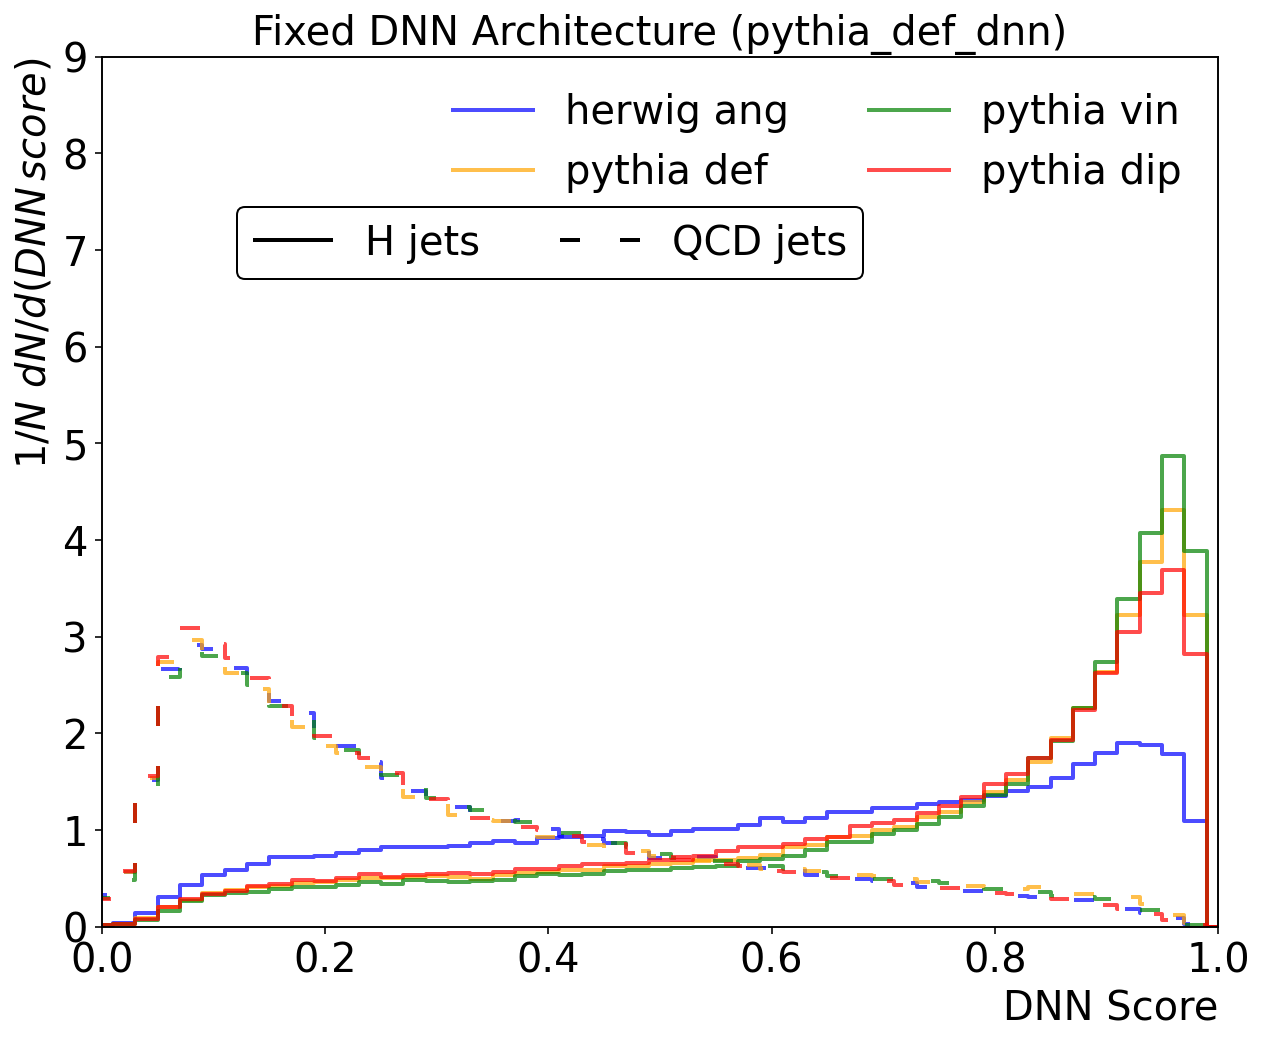

CPU times: user 519 ms, sys: 31.1 ms, total: 550 ms
Wall time: 533 ms


In [52]:
%%time


architecture = "pythia_def_dnn"
model_type = "DNN"

xbin = np.linspace(-1,2,151)

fig, ax = plt.subplots(figsize=(10,8))
Datatest = pd.DataFrame()
Datatest["target"] = data_train["herwig_ang_train"]["target"]
Datatest["pre"] = data_train["herwig_ang_train"][architecture+"_pre"]
inner = Datatest[Datatest["target"]==1]
outter = Datatest[Datatest["target"]==0]

H_hist, H_bins = np.histogram(inner["pre"], bins=xbin)
plt.step(H_bins[:-1], H_hist.astype(np.float32)/sum(H_hist)/0.02 ,color = "blue", linestyle="-", where='mid',linewidth=2, alpha=0.7, label="herwig ang")  #,label="truth H jets"
QCD_hist, QCD_bins = np.histogram(outter["pre"], bins=xbin)
plt.step(QCD_bins[:-1], QCD_hist.astype(np.float32)/sum(QCD_hist)/0.02 ,color = "blue", linestyle=(0,(5, 10)), where='mid',linewidth=2, alpha=0.7)  #,label="truth QCD jets"


Datatest = pd.DataFrame()
Datatest["target"] = data_train["pythia_def_train"]["target"]
Datatest["pre"] = data_train["pythia_def_train"][architecture+"_pre"]
inner = Datatest[Datatest["target"]==1]
outter = Datatest[Datatest["target"]==0]

H_hist, H_bins = np.histogram(inner["pre"], bins=xbin)
plt.step(H_bins[:-1], H_hist.astype(np.float32)/sum(H_hist)/0.02 ,color = "orange", linestyle="-", where='mid',linewidth=2, alpha=0.7,label="pythia def") 
QCD_hist, QCD_bins = np.histogram(outter["pre"], bins=xbin)
plt.step(QCD_bins[:-1], QCD_hist.astype(np.float32)/sum(QCD_hist)/0.02 ,color = "orange", linestyle=(0,(5, 10)), where='mid',linewidth=2, alpha=0.7)  #,label="truth QCD jets"



Datatest = pd.DataFrame()
Datatest["target"] = data_train["pythia_vin_train"]["target"]
Datatest["pre"] = data_train["pythia_vin_train"][architecture+"_pre"]
inner = Datatest[Datatest["target"]==1]
outter = Datatest[Datatest["target"]==0]

H_hist, H_bins = np.histogram(inner["pre"], bins=xbin)
plt.step(H_bins[:-1], H_hist.astype(np.float32)/sum(H_hist)/0.02 , color = "green", linestyle="-", where='mid',linewidth=2, alpha=0.7,label="pythia vin") 
QCD_hist, QCD_bins = np.histogram(outter["pre"], bins=xbin)
plt.step(QCD_bins[:-1], QCD_hist.astype(np.float32)/sum(QCD_hist)/0.02 ,color = "green", linestyle=(0,(5, 10)), where='mid',linewidth=2, alpha=0.7) 


Datatest = pd.DataFrame()
Datatest["target"] = data_train["pythia_dip_train"]["target"]
Datatest["pre"] = data_train["pythia_dip_train"][architecture+"_pre"]
inner = Datatest[Datatest["target"]==1]
outter = Datatest[Datatest["target"]==0]

H_hist, H_bins = np.histogram(inner["pre"], bins=xbin)
plt.step(H_bins[:-1], H_hist.astype(np.float32)/sum(H_hist)/0.02 , color = "red", linestyle="-", where='mid',linewidth=2, alpha=0.7,label="pythia dip") 
QCD_hist, QCD_bins = np.histogram(outter["pre"], bins=xbin)
plt.step(QCD_bins[:-1], QCD_hist.astype(np.float32)/sum(QCD_hist)/0.02 ,color = "red", linestyle=(0,(5, 10)), where='mid',linewidth=2, alpha=0.7) 



plt.xlim((0,1))
plt.ylim((0,9))

plt.title("Fixed "+model_type+" Architecture ("+str(architecture)+")", fontsize=20)

plt.xlabel(model_type+" Score", fontsize=20,horizontalalignment='right',x=1)
plt.ylabel("$1/N\,\,dN/d ("+model_type+"\, score)$",fontsize=20,horizontalalignment='right',y=1)
# plt.legend(loc="best",ncol=2,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.5, 1)


ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)



ax2 = ax.twinx()
plt.hlines(0.9, 0.8, 0.8, color="black", linestyle="-", linewidth = 2,label="H jets")
plt.hlines(0.9, 0.8, 0.8, color="black", linestyle=(0,(5, 10)), linewidth = 2,label="QCD jets")

ax2.get_yaxis().set_visible(False)


ax.legend(loc="best",ncol=2,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
ax2.legend(bbox_to_anchor=(0.7, 0.85),ncol=2,fontsize=20, edgecolor = "k",fancybox=True, framealpha=1)





plt.show()

In [53]:
%%time

for name in DNN_Model_A1:
    auc = metrics.roc_auc_score(data_train[name+"_train"]["target"], data_train[name+"_train"]["pythia_def_dnn_pre"])
    print(name,auc)

herwig_ang 0.801614370799904
pythia_def 0.858486396000752
pythia_vin 0.8731039786088373
pythia_dip 0.8648498959702353
CPU times: user 284 ms, sys: 27.1 ms, total: 312 ms
Wall time: 308 ms


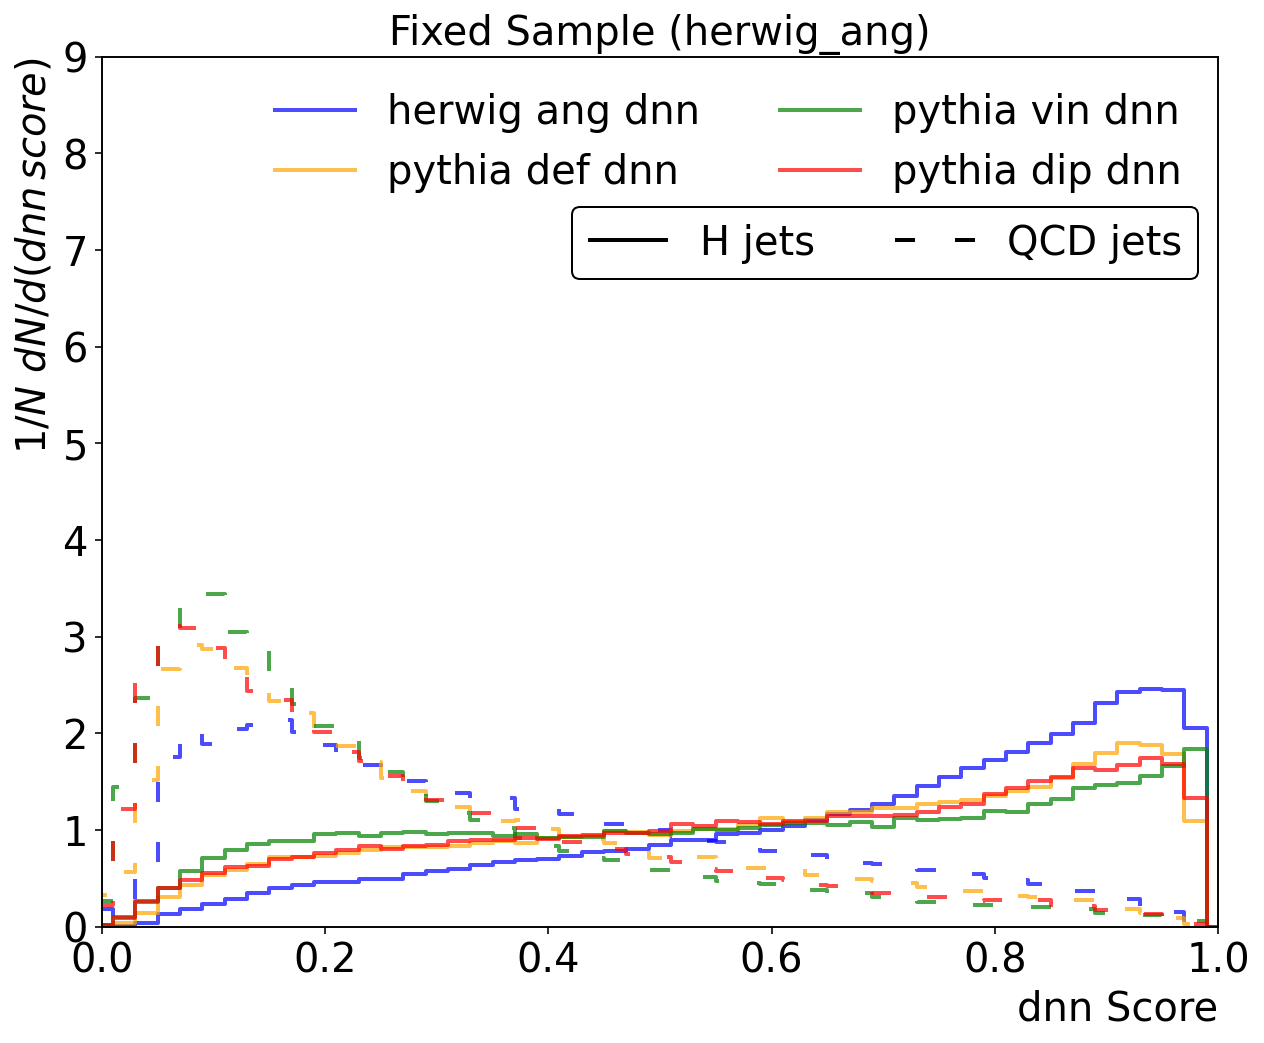

CPU times: user 522 ms, sys: 36 ms, total: 558 ms
Wall time: 539 ms


In [49]:
%%time


sample = "herwig_ang"
model_type = "dnn"

xbin = np.linspace(-1,2,151)

fig, ax = plt.subplots(figsize=(10,8))

Datatest = pd.DataFrame()
Datatest["target"] = data_train[sample+"_train"]["target"]
Datatest["pre"] = data_train[sample+"_train"]["herwig_ang_"+model_type+"_pre"]
inner = Datatest[Datatest["target"]==1]
outter = Datatest[Datatest["target"]==0]

H_hist, H_bins = np.histogram(inner["pre"], bins=xbin)
plt.step(H_bins[:-1], H_hist.astype(np.float32)/sum(H_hist)/0.02 ,color = "blue", linestyle="-", where='mid',linewidth=2, alpha=0.7, label="herwig ang "+model_type)  #,label="truth H jets"
QCD_hist, QCD_bins = np.histogram(outter["pre"], bins=xbin)
plt.step(QCD_bins[:-1], QCD_hist.astype(np.float32)/sum(QCD_hist)/0.02 ,color = "blue", linestyle=(0,(5, 10)), where='mid',linewidth=2, alpha=0.7)  #,label="truth QCD jets"


Datatest = pd.DataFrame()
Datatest["target"] = data_train[sample+"_train"]["target"]
Datatest["pre"] = data_train[sample+"_train"]["pythia_def_"+model_type+"_pre"]
inner = Datatest[Datatest["target"]==1]
outter = Datatest[Datatest["target"]==0]

H_hist, H_bins = np.histogram(inner["pre"], bins=xbin)
plt.step(H_bins[:-1], H_hist.astype(np.float32)/sum(H_hist)/0.02 ,color = "orange", linestyle="-", where='mid',linewidth=2, alpha=0.7,label="pythia def "+model_type) 
QCD_hist, QCD_bins = np.histogram(outter["pre"], bins=xbin)
plt.step(QCD_bins[:-1], QCD_hist.astype(np.float32)/sum(QCD_hist)/0.02 ,color = "orange", linestyle=(0,(5, 10)), where='mid',linewidth=2, alpha=0.7)  #,label="truth QCD jets"



Datatest = pd.DataFrame()
Datatest["target"] = data_train[sample+"_train"]["target"]
Datatest["pre"] = data_train[sample+"_train"]["pythia_vin_"+model_type+"_pre"]
inner = Datatest[Datatest["target"]==1]
outter = Datatest[Datatest["target"]==0]

H_hist, H_bins = np.histogram(inner["pre"], bins=xbin)
plt.step(H_bins[:-1], H_hist.astype(np.float32)/sum(H_hist)/0.02 , color = "green", linestyle="-", where='mid',linewidth=2, alpha=0.7,label="pythia vin "+model_type) 
QCD_hist, QCD_bins = np.histogram(outter["pre"], bins=xbin)
plt.step(QCD_bins[:-1], QCD_hist.astype(np.float32)/sum(QCD_hist)/0.02 ,color = "green", linestyle=(0,(5, 10)), where='mid',linewidth=2, alpha=0.7) 


Datatest = pd.DataFrame()
Datatest["target"] = data_train[sample+"_train"]["target"]
Datatest["pre"] = data_train[sample+"_train"]["pythia_dip_"+model_type+"_pre"]
inner = Datatest[Datatest["target"]==1]
outter = Datatest[Datatest["target"]==0]

H_hist, H_bins = np.histogram(inner["pre"], bins=xbin)
plt.step(H_bins[:-1], H_hist.astype(np.float32)/sum(H_hist)/0.02 , color = "red", linestyle="-", where='mid',linewidth=2, alpha=0.7,label="pythia dip "+model_type) 
QCD_hist, QCD_bins = np.histogram(outter["pre"], bins=xbin)
plt.step(QCD_bins[:-1], QCD_hist.astype(np.float32)/sum(QCD_hist)/0.02 ,color = "red", linestyle=(0,(5, 10)), where='mid',linewidth=2, alpha=0.7) 


plt.xlim((0,1))
plt.ylim((0,9))


plt.title("Fixed Sample ("+str(sample)+")", fontsize=20)

plt.xlabel(model_type+" Score", fontsize=20,horizontalalignment='right',x=1)
plt.ylabel("$1/N\,\,dN/d ("+model_type+"\, score)$",fontsize=20,horizontalalignment='right',y=1)
# plt.legend(loc="best",ncol=2,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.5, 1)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


ax2 = ax.twinx()
plt.hlines(0.9, 0.8, 0.8, color="black", linestyle="-", linewidth = 2,label="H jets")
plt.hlines(0.9, 0.8, 0.8, color="black", linestyle=(0,(5, 10)), linewidth = 2,label="QCD jets")

ax2.get_yaxis().set_visible(False)


ax.legend(loc="best",ncol=2,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
ax2.legend(bbox_to_anchor=(1, 0.85),ncol=2,fontsize=20, edgecolor = "k",fancybox=True, framealpha=1)


plt.show()

In [50]:
%%time

for name in DNN_Model_A1:
    auc = metrics.roc_auc_score(data_train["herwig_ang_train"]["target"], data_train["herwig_ang_train"][name+"_dnn_pre"])
    print(name,auc)

herwig_ang 0.8197605801863268
pythia_def 0.801614370799904
pythia_vin 0.8133367694082644
pythia_dip 0.8167698436507664
CPU times: user 289 ms, sys: 9.81 ms, total: 298 ms
Wall time: 295 ms


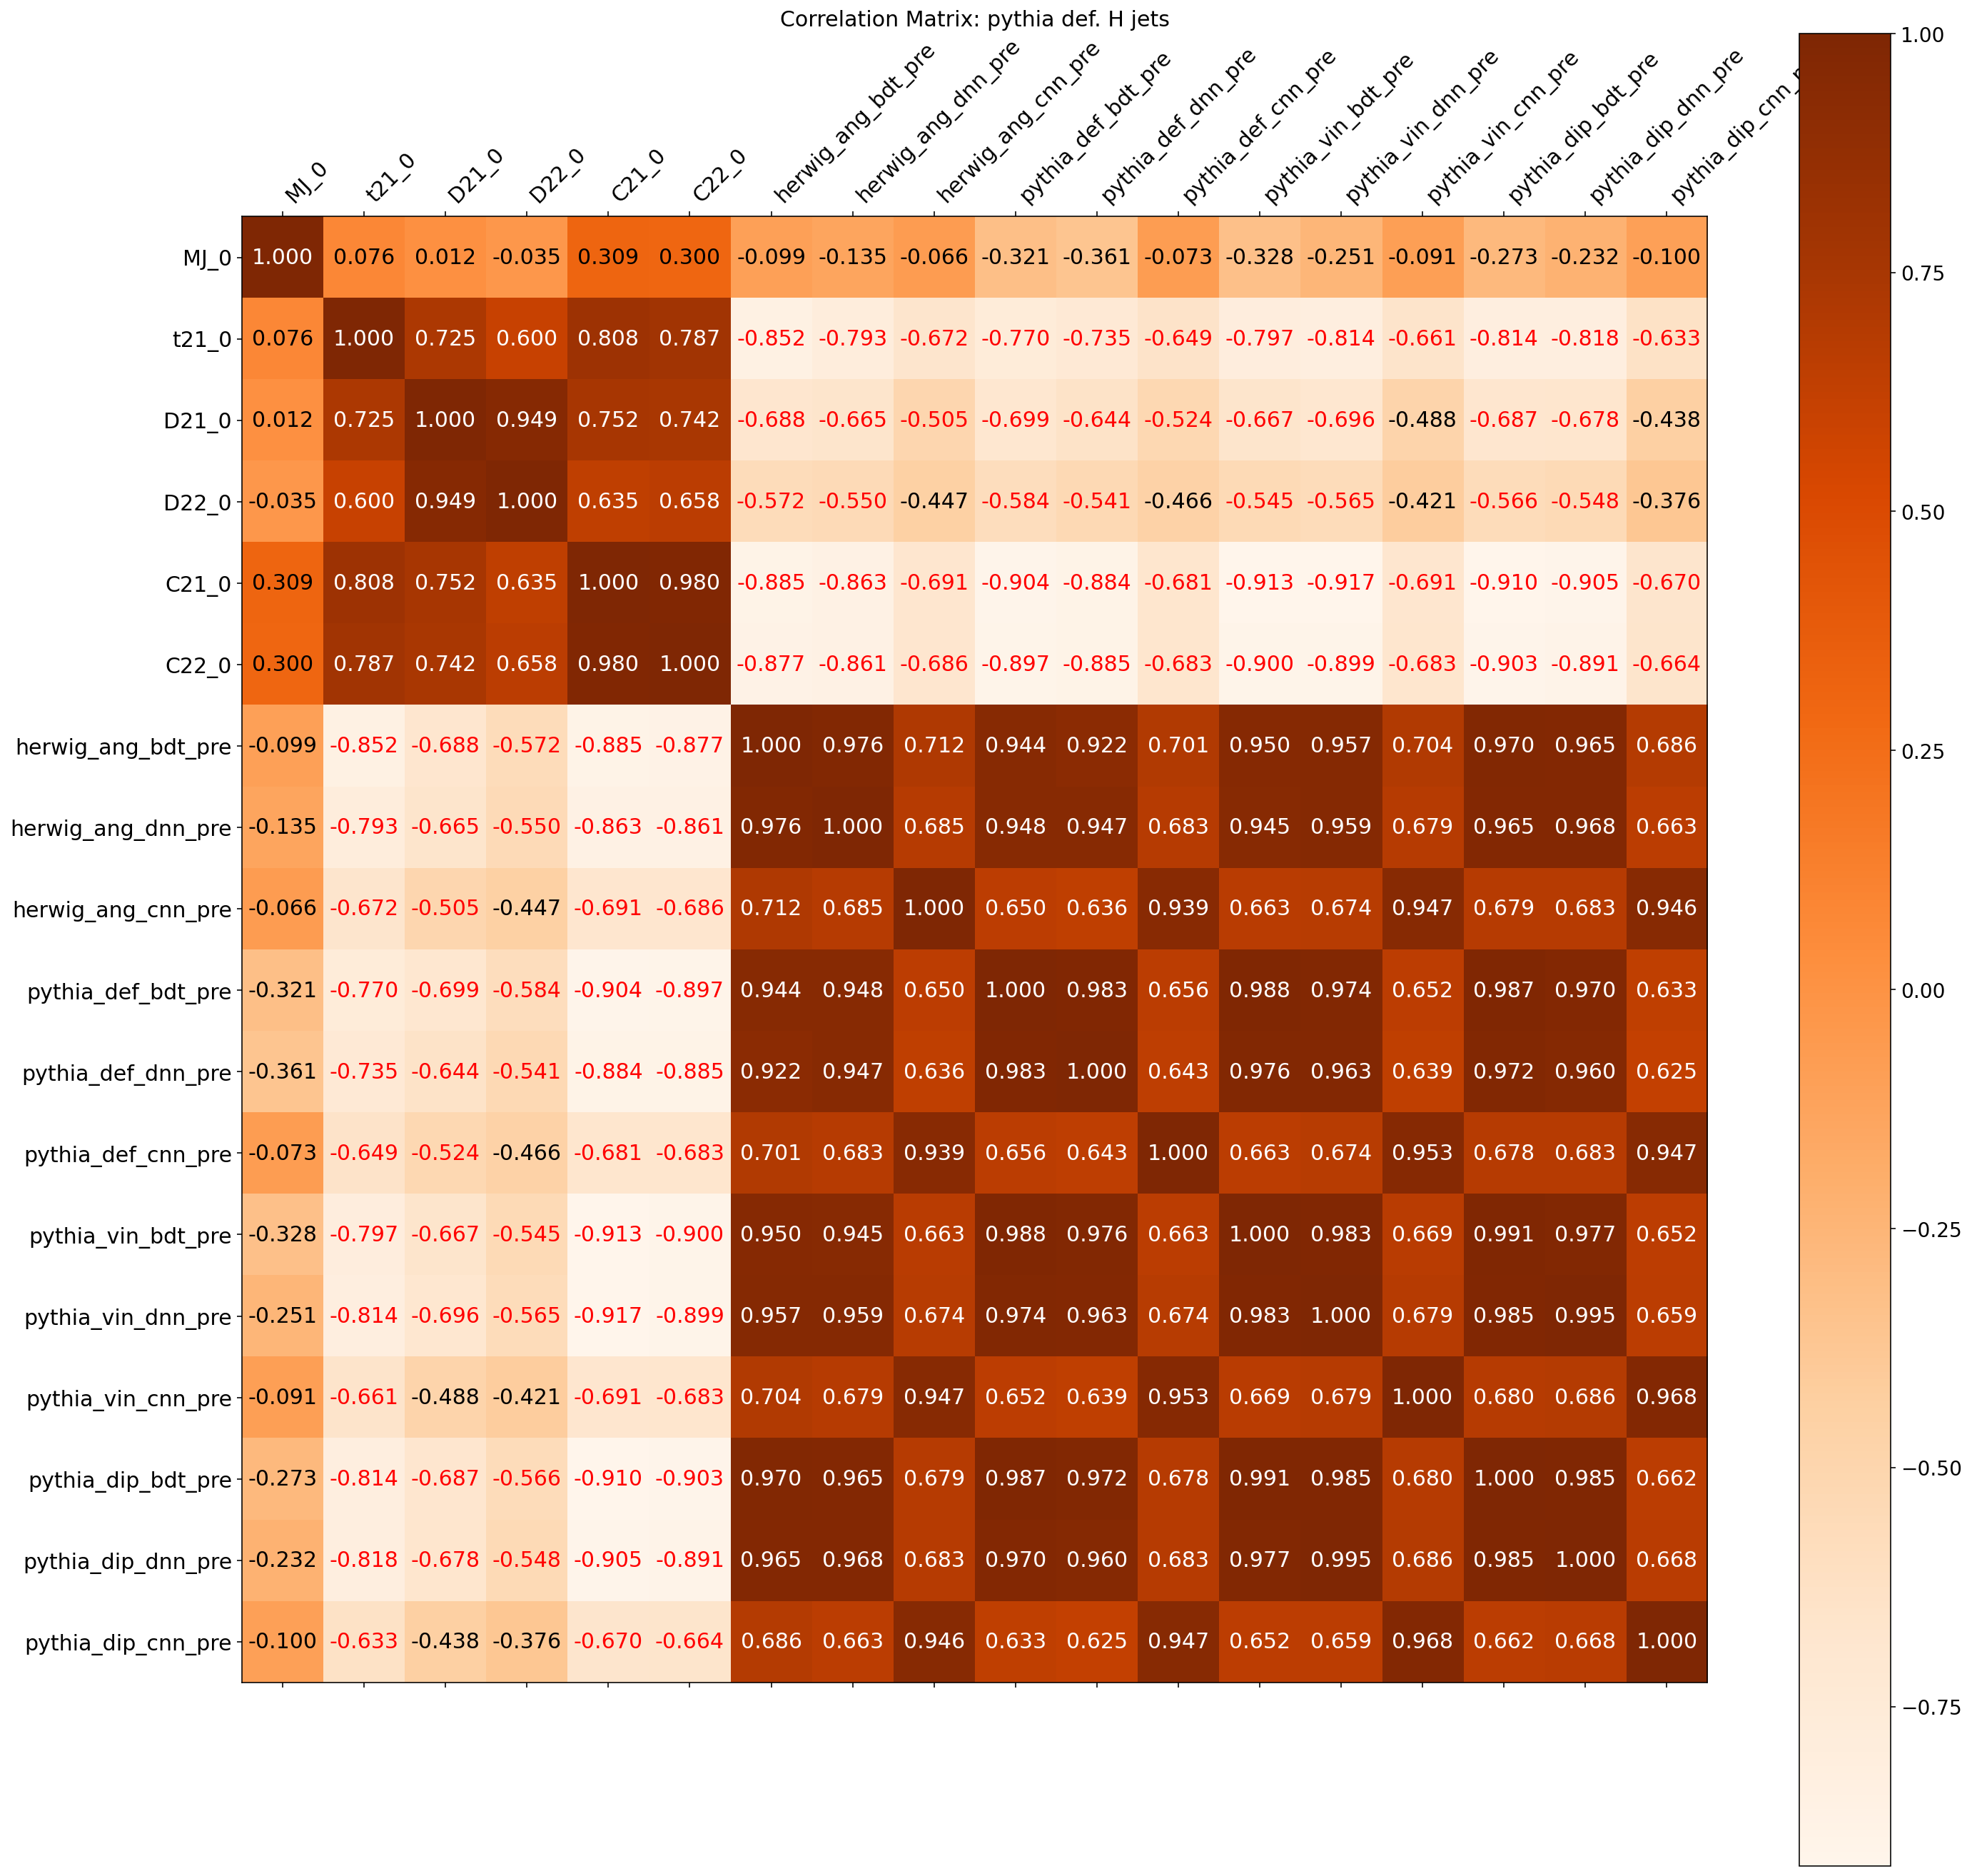

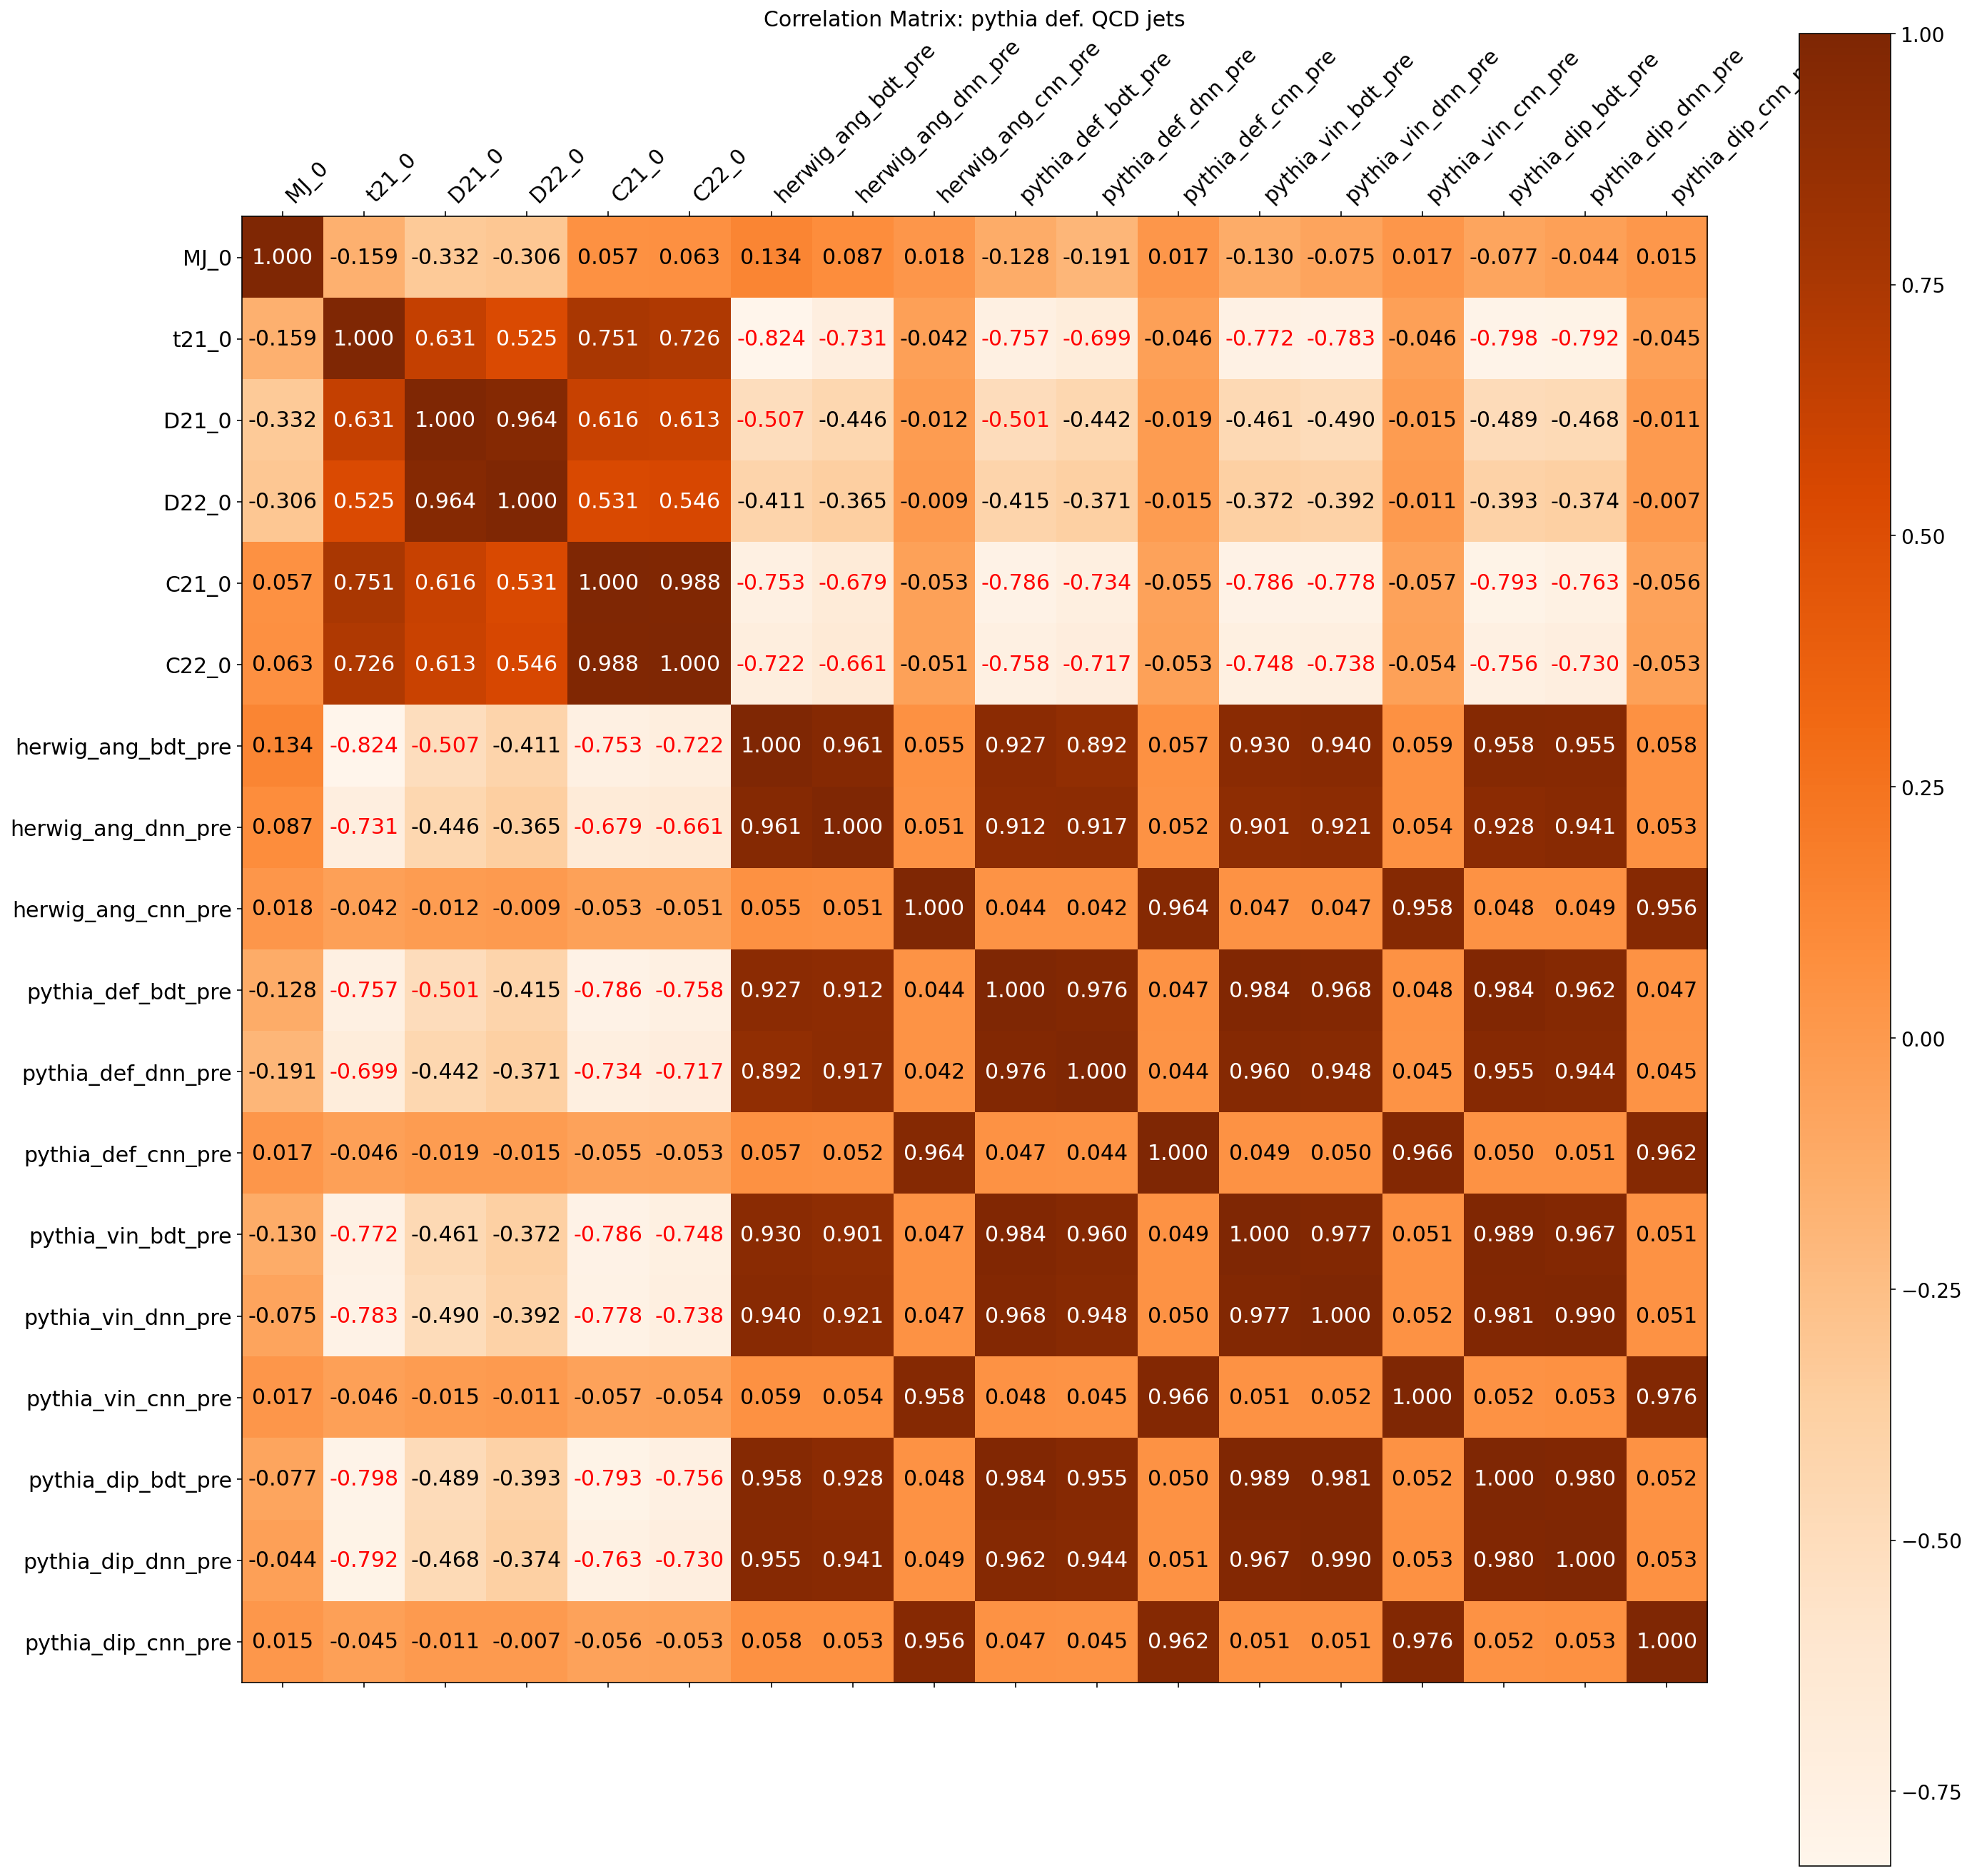

CPU times: user 5.33 s, sys: 1.43 s, total: 6.76 s
Wall time: 6.03 s


In [55]:
%%time

"""
Correlation Table Ploting Function
"""
def correlation_table(dataframe, namelist, title):
    s = len(namelist)
    f = plt.figure(figsize=(s+5, s+5))

    plt.matshow(dataframe.corr(),fignum=f.number, cmap="Oranges")    # calculate correlation: dataframe.corr()
    plt.xticks(range(dataframe.shape[1]), namelist, fontsize=15, rotation=45, ha="left")
    plt.yticks(range(dataframe.shape[1]), namelist, fontsize=15)
    # plt.ylim((9.5,-0.5))
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    # plt.title('Correlation Matrix', fontsize=16)
    for (i, j), z in np.ndenumerate(dataframe.corr()):
        if z >=0.5:
            colors = "white"
        elif z <= -0.5:
            colors = "red"
        else :
            colors = "black"
        plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',fontsize=15,color=colors)
    plt.title('Correlation Matrix: ' +title, fontsize=15)
    plt.show()



features =  ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0",
             'herwig_ang_bdt_pre', 'herwig_ang_dnn_pre','herwig_ang_cnn_pre', 
             'pythia_def_bdt_pre', 'pythia_def_dnn_pre','pythia_def_cnn_pre', 
             'pythia_vin_bdt_pre', 'pythia_vin_dnn_pre','pythia_vin_cnn_pre', 
             'pythia_dip_bdt_pre', 'pythia_dip_dnn_pre','pythia_dip_cnn_pre']

namelist = ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0",
             'herwig_ang_bdt_pre', 'herwig_ang_dnn_pre','herwig_ang_cnn_pre', 
             'pythia_def_bdt_pre', 'pythia_def_dnn_pre','pythia_def_cnn_pre', 
             'pythia_vin_bdt_pre', 'pythia_vin_dnn_pre','pythia_vin_cnn_pre', 
             'pythia_dip_bdt_pre', 'pythia_dip_dnn_pre','pythia_dip_cnn_pre']

H_sample = data_train["pythia_def_train"][data_train["pythia_def_train"]["PRO"] == "H"]
QCD_sample = data_train["pythia_def_train"][data_train["pythia_def_train"]["PRO"] == "QCD"]

correlation_table(H_sample[features], namelist, "pythia def. H jets")
correlation_table(QCD_sample[features], namelist, "pythia def. QCD jets")


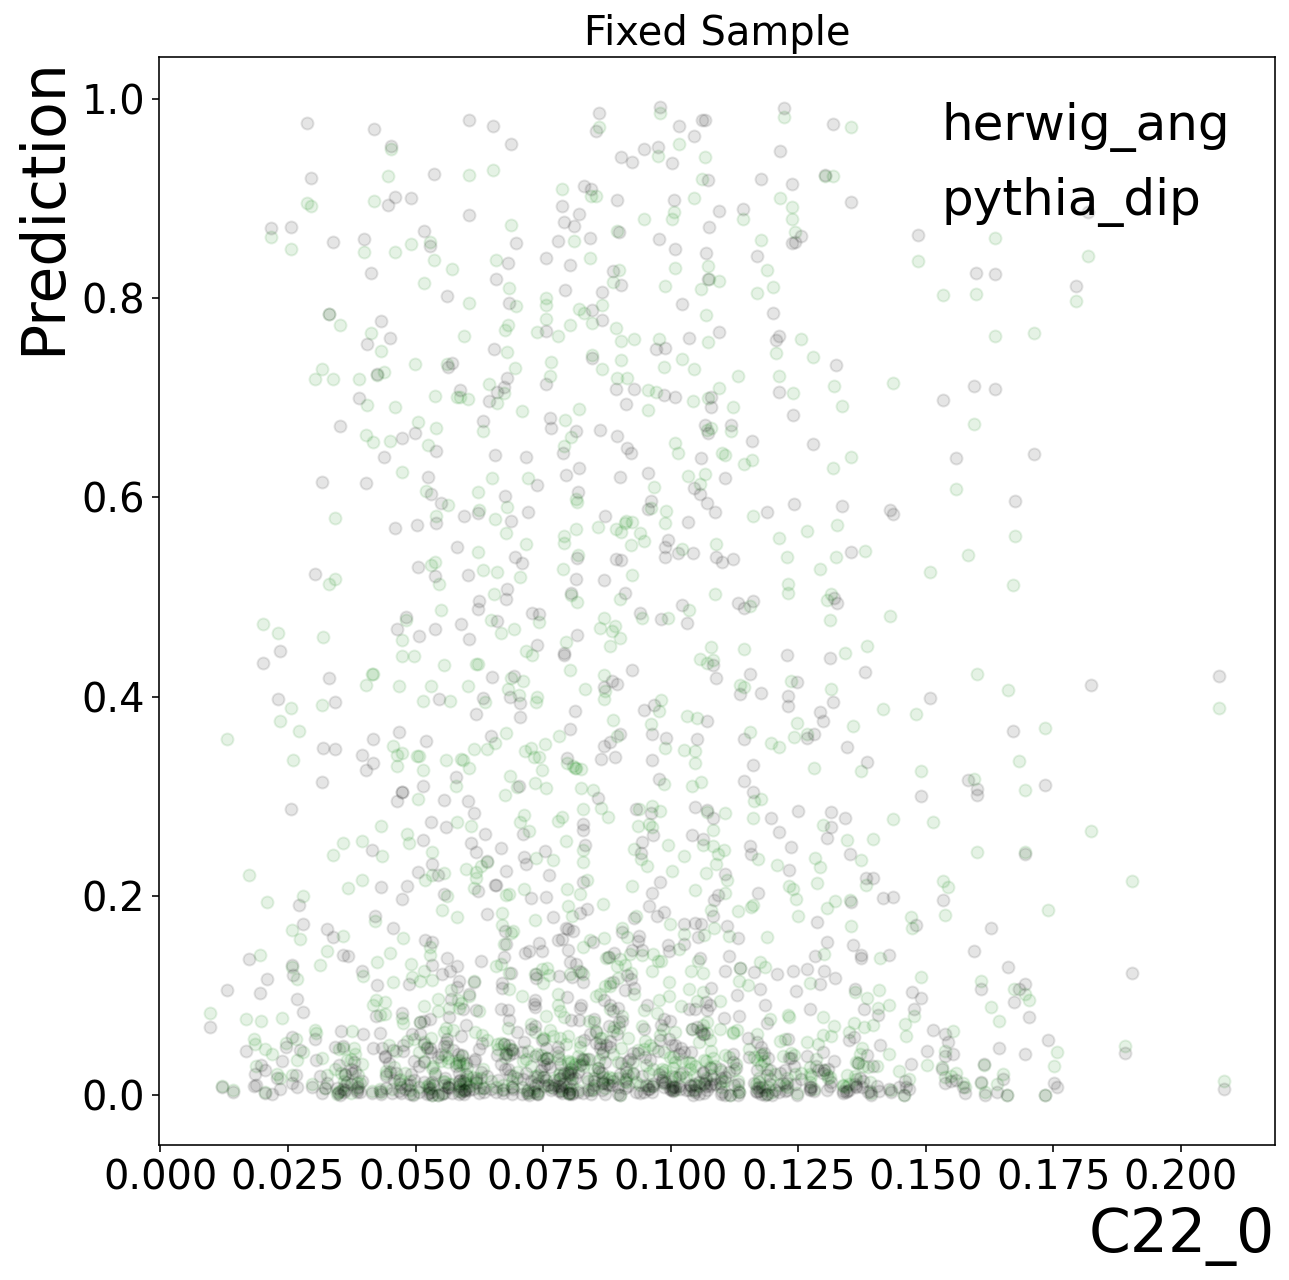

CPU times: user 435 ms, sys: 45.2 ms, total: 480 ms
Wall time: 478 ms


In [15]:
%%time


features =  ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0",'herwig_ang_pre', 'pythia_def_pre', 'pythia_vin_pre','pythia_dip_pre']

H_sample = data_train["herwig_ang_train"][data_train["herwig_ang_train"]["PRO"] == "H"]
QCD_sample = data_train["herwig_ang_train"][data_train["herwig_ang_train"]["PRO"] == "QCD"]

variable = "C22_0"
sample = shuffle(QCD_sample)

fig, ax = plt.subplots(1,1, figsize=(10,10))


plt.scatter(sample[variable][:1000],sample["herwig_ang_cnn_pre"][:1000], c= "green", alpha=0.1, label = "herwig_ang")
# plt.scatter(sample[variable][:1000],sample["pythia_def_pre"][:1000], c= "red", alpha=0.1, label = "pythia_def")
# plt.scatter(sample[variable][:1000],sample["pythia_vin_pre"][:1000], c= "blue", alpha=0.1, label = "pythia_vin")
plt.scatter(sample[variable][:1000],sample["pythia_dip_cnn_pre"][:1000], c= "black", alpha=0.1, label = "pythia_dip")


# plt.scatter(QCD_sample[variable][:1000],QCD_sample["herwig_ang_pre"][:1000], marker="s", c= "green", alpha=0.2, label = "herwig_ang")
# # plt.scatter(sample[variable][:1000],sample["pythia_def_pre"][:1000], c= "red", alpha=0.1, label = "pythia_def")
# # plt.scatter(sample[variable][:1000],sample["pythia_vin_pre"][:1000], c= "blue", alpha=0.1, label = "pythia_vin")
# plt.scatter(QCD_sample[variable][:1000],QCD_sample["pythia_dip_pre"][:1000], marker="s",  c= "black", alpha=0.2, label = "pythia_dip")


ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.xlabel(variable, fontsize=30,horizontalalignment='right',x=1)
plt.ylabel("Prediction", fontsize=30,horizontalalignment='right',y=1)
plt.title("Fixed Sample", fontsize=20)

plt.legend(loc="best",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0) 
plt.show()


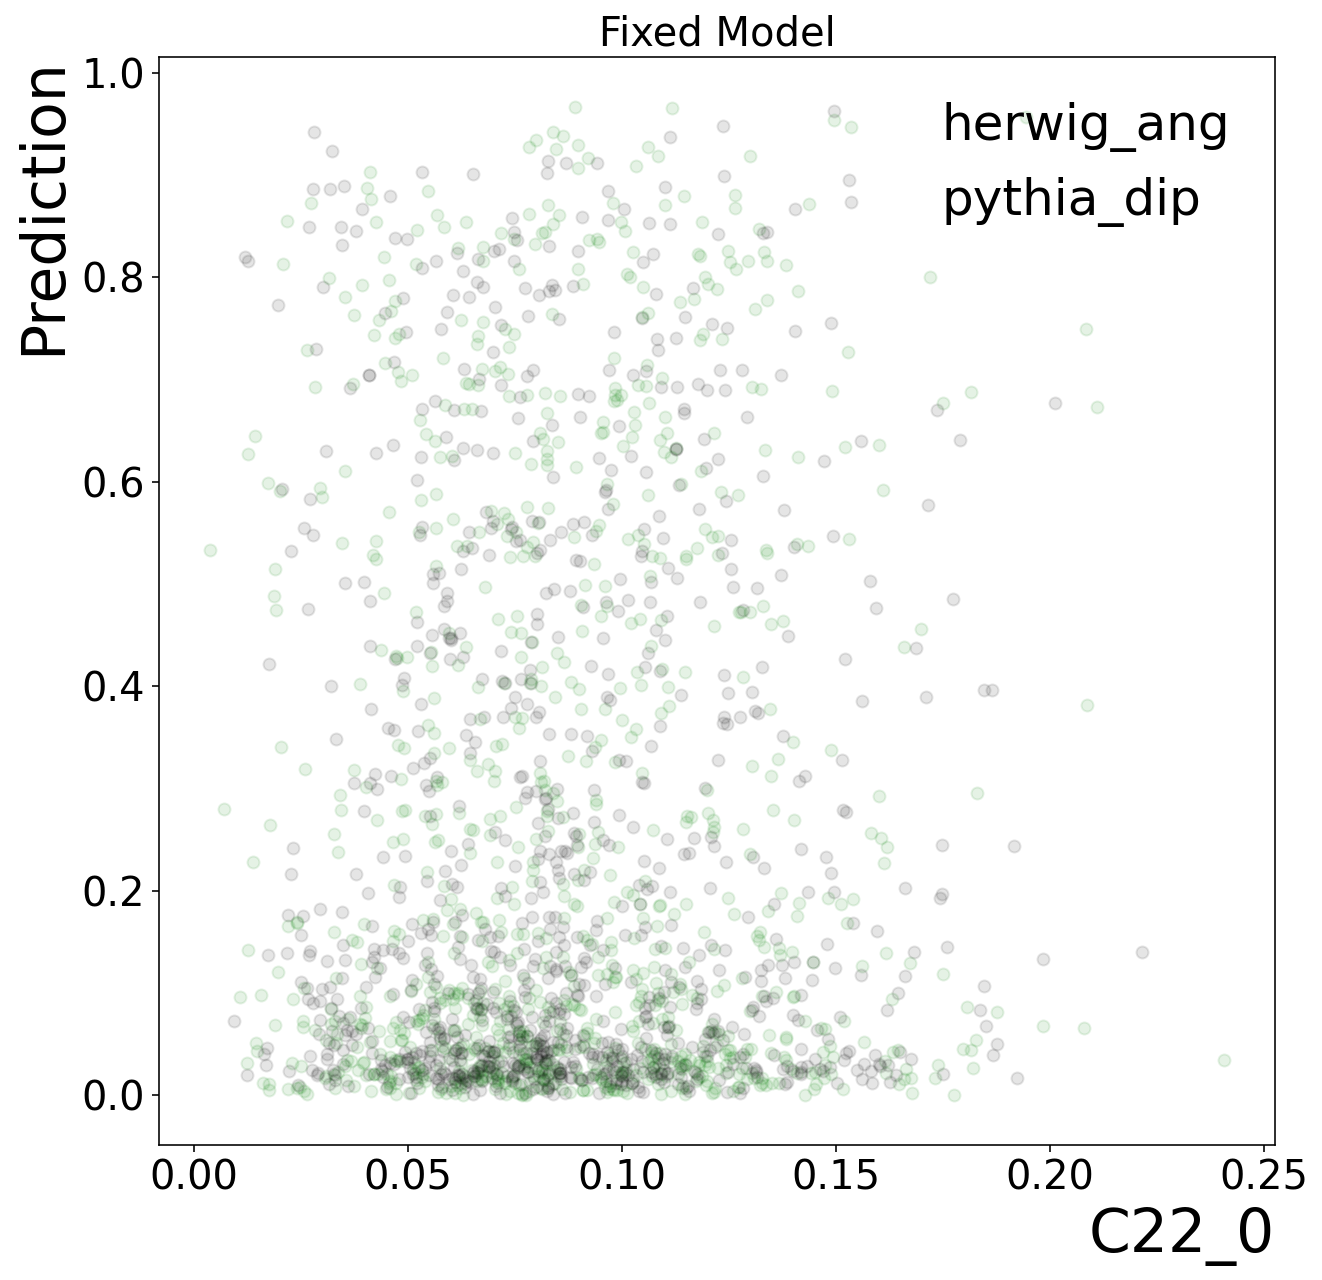

In [13]:
features =  ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0",'herwig_ang_pre', 'pythia_def_pre', 'pythia_vin_pre','pythia_dip_pre']

variable = "C22_0"
jet_type = "QCD"

fig, ax = plt.subplots(1,1, figsize=(10,10))


plt.scatter(data_train["herwig_ang_train"][data_train["herwig_ang_train"]["PRO"] == jet_type][variable][:1000],
            data_train["herwig_ang_train"][data_train["herwig_ang_train"]["PRO"] == jet_type]["herwig_ang_cnn_pre"][:1000],
            c= "green", alpha=0.1, label = "herwig_ang")

# plt.scatter(data_train["pythia_def_train"][data_train["pythia_def_train"]["PRO"] == jet_type][variable][:1000],
#             data_train["pythia_def_train"][data_train["pythia_def_train"]["PRO"] == jet_type]["herwig_ang_pre"][:1000],
#             c= "red", alpha=0.1, label = "pythia_def")

# plt.scatter(data_train["pythia_vin_train"][data_train["pythia_vin_train"]["PRO"] == jet_type][variable][:1000],
#             data_train["pythia_vin_train"][data_train["pythia_vin_train"]["PRO"] == jet_type]["herwig_ang_pre"][:1000],
#             c= "blue", alpha=0.1, label = "pythia_vin")

plt.scatter(data_train["pythia_dip_train"][data_train["pythia_dip_train"]["PRO"] == jet_type][variable][:1000],
            data_train["pythia_dip_train"][data_train["pythia_dip_train"]["PRO"] == jet_type]["herwig_ang_cnn_pre"][:1000],
            c= "black", alpha=0.1, label = "pythia_dip")



ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.xlabel(variable, fontsize=30,horizontalalignment='right',x=1)
plt.ylabel("Prediction", fontsize=30,horizontalalignment='right',y=1)
plt.title("Fixed Model", fontsize=20)

# plt.xlim((0,0.05))

plt.legend(loc="best",ncol=1,fontsize=25, edgecolor = "w",fancybox=False, framealpha=0) 
plt.show()

In [ ]:
# %%time
# HOMEPATH = "/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/"
# datapath = HOMEPATH + "Data_ML/Data_High_Level_Features/"

# tmpH = pd.read_csv(datapath + "pythia_def_H_250_500_1.csv")
# tmpQCD = pd.read_csv(datapath + "pythia_def_QCD_250_500_1.csv")

# pythia_def_test_csv = pd.concat([tmpH, tmpQCD], ignore_index=True, axis=0,join='inner')

# tmpH = np.load("./pythia_def_H_250_500_1_untrimmed.npz")
# tmpQCD = np.load("pythia_def_QCD_250_500_1_untrimmed.npz")

# pythia_def_test_npz = np.concatenate((tmpH["jet_images"],tmpQCD["jet_images"]))

# features = ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0"]

# BDT = load("./KFold_BDT/pythia_def_KFold/BDT_pythia_def_Models_300500/pythia_def_BDT_0.h5")
# prediction = BDT.predict_proba(np.asarray(pythia_def_test_csv[features]))[:,1]
# pythia_def_test_csv["pythia_def_bdt_pre"] = prediction/(max(prediction))

# DNN = load_model("./KFold/pythia_def_KFold/DNN_pythia_def_Models_300500/pythia_def_DNN_0.h5")
# prediction = DNN_Model_A1[element].predict(np.asarray(pythia_def_test_csv[features]))
# pythia_def_test_csv["pythia_def_dnn_pre"] = prediction/(max(prediction))


# CNN = load_model("./KFold_CNN/pythia_def_KFold/CNN_pythia_def_Models_300500/pythia_def_CNN_0.h5")
# prediction = CNN.predict(pythia_def_test_npz)
# pythia_def_test_csv["pythia_def_cnn_pre"] = prediction/(max(prediction))

# """
# Correlation Table Ploting Function
# """
# def correlation_table(dataframe, namelist, title):
#     s = len(namelist)
#     f = plt.figure(figsize=(s+5, s+5))

#     plt.matshow(dataframe.corr(),fignum=f.number, cmap="Oranges")    # calculate correlation: dataframe.corr()
#     plt.xticks(range(dataframe.shape[1]), namelist, fontsize=15, rotation=45, ha="left")
#     plt.yticks(range(dataframe.shape[1]), namelist, fontsize=15)
#     # plt.ylim((9.5,-0.5))
#     cb = plt.colorbar()
#     cb.ax.tick_params(labelsize=14)
#     # plt.title('Correlation Matrix', fontsize=16)
#     for (i, j), z in np.ndenumerate(dataframe.corr()):
#         if z >=0.5:
#             colors = "white"
#         elif z <= -0.5:
#             colors = "red"
#         else :
#             colors = "black"
#         plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',fontsize=15,color=colors)
#     plt.title('Correlation Matrix: ' +title, fontsize=15)
#     plt.show()



# features =  ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0",
# #              'herwig_ang_bdt_pre', 'herwig_ang_dnn_pre','herwig_ang_cnn_pre', 
#              'pythia_def_bdt_pre', 'pythia_def_dnn_pre','pythia_def_cnn_pre', 
# #              'pythia_vin_bdt_pre', 'pythia_vin_dnn_pre','pythia_vin_cnn_pre', 
# #              'pythia_dip_bdt_pre', 'pythia_dip_dnn_pre','pythia_dip_cnn_pre'
#             ]

# namelist = ["MJ_0","t21_0","D21_0","D22_0","C21_0","C22_0",
# #              'herwig_ang_bdt_pre', 'herwig_ang_dnn_pre','herwig_ang_cnn_pre', 
#              'pythia_def_bdt_pre', 'pythia_def_dnn_pre','pythia_def_cnn_pre', 
# #              'pythia_vin_bdt_pre', 'pythia_vin_dnn_pre','pythia_vin_cnn_pre', 
# #              'pythia_dip_bdt_pre', 'pythia_dip_dnn_pre','pythia_dip_cnn_pre'
#            ]

# H_sample = pythia_def_test_csv[pythia_def_test_csv["PRO"] == "H"]
# QCD_sample = pythia_def_test_csv[pythia_def_test_csv["PRO"] == "QCD"]

# correlation_table(H_sample[features], namelist, "pythia def. H jets")
# correlation_table(QCD_sample[features], namelist, "pythia def. QCD jets")